# SAS_ml_1m

In [ ]:
!nvidia-smi

Sun Dec 10 14:37:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# mount my drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

'302 남.mp4'				   'Que Onda III.pdf'
 8.acl					   'Transformer 기반 RC.gdoc'
 Classroom				   '더위 체크 상품권 🎁   정보 입력.gform'
'Colab Notebooks'			    데이터마블링_데이터마이닝_최종보고서.zip
'Data Mining Term Project_Proposal.gdoc'   '비긴어게인 LAMP OPEN MIC 참석 여부.gform'
'K-water 공모전.gdoc'			   '비긴어게인 사연 작성 양식(응답).gsheet'
'NETFLIX 서비스 개선을 위한 설문지.gform'   신년인사_도현.mp4
'Que onda 2 듣기 파일'			   '통계 프로젝트 설문지.gform'


In [2]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

## 1. Training Configuration

In [5]:
config = {
    'data_path': "/content/gdrive/MyDrive/Colab Notebooks/REC/ml-1m",
    'max_len': 200,  # Set to 200 for ML-1m
    'hidden_units': 64,  # 32 units per head, 2 heads
    'num_heads': 2,
    'num_layers': 2,
    'dropout_rate': 0.5,  # Unspecified, can be adjusted
    'lr': 1e-4,
    'batch_size': 256,
    'num_epochs': 30,  # Unspecified, can be adjusted
    'num_workers': 2,  # Unspecified, can be adjusted
    'mask_prob': 0.2  # Set to 0.2 for ML-1m
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [6]:
# ml-1m
# user
ml_1m_users_col = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
ml_1m_users_col = [col.lower() for col in ml_1m_users_col]
ml_1m_users = pd.read_csv(config.data_path + '/users.dat', sep='::', header=None, names=ml_1m_users_col)
print(ml_1m_users.columns)
# movies
ml_1m_movies_col = ['MovieID','Title','Genres']
ml_1m_movies_col = [col.lower() for col in ml_1m_movies_col]
ml_1m_movies = pd.read_csv(config.data_path + '/movies.dat', sep='::', header=None, names=ml_1m_movies_col, encoding='Latin-1')
print(ml_1m_movies.columns)
# ratings
ml_1m_ratings_col = ['UserID','MovieID','Rating','Timestamp']
ml_1m_ratings_col = [col.lower() for col in ml_1m_ratings_col]
ml_1m_ratings = pd.read_csv(config.data_path + '/ratings.dat', sep='::', header=None, names=ml_1m_ratings_col, encoding='Latin-1')
print(ml_1m_ratings.columns)

Index(['userid', 'gender', 'age', 'occupation', 'zip-code'], dtype='object')
Index(['movieid', 'title', 'genres'], dtype='object')
Index(['userid', 'movieid', 'rating', 'timestamp'], dtype='object')


## 2. Data pre-processing

In [21]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = ml_1m_ratings
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieid')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userid')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieid'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userid'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # sorting by timestamp
        self.user_train, self.user_valid, self.user_test = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder define

        Args:
            col (str): define columns 명
        Returns:
            dict: define user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def generate_sequence_data(self):
        users = defaultdict(list)
        user_train, user_valid, user_test = {}, {}, {}
        group_df = self.df.groupby('user_idx')

        for user, item in group_df:
            user_seq = item['item_idx'].tolist()
            if len(user_seq) < 3:
                continue
            user_train[user] = user_seq[:-2]
            user_valid[user] = user_seq[-2:-1]
            user_test[user] = user_seq[-1:]

        return user_train, user_valid, user_test

    def get_data(self):
        return self.user_train, self.user_valid, self.user_test

In [22]:
class SASRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        # number of user = number of sequence using training
        return self.num_user

    def __getitem__(self, user):

        user_seq = self.user_train[user]
        user_seq_len = len(user_seq)

        seq = user_seq[-(user_seq_len) : -1]
        seq = seq[-self.max_len :]

        pos = user_seq[-(user_seq_len - 1) : ]
        pos = pos[-self.max_len :]

        neg = random.sample(list(self._all_items - set(user_seq)), len(pos))

        seq = [0] * (self.max_len - len(seq)) + seq
        pos = [0] * (self.max_len - len(pos)) + pos
        neg = [0] * (self.max_len - len(neg)) + neg

        return np.array(seq, dtype=np.int32), np.array(pos, dtype=np.int32), np.array(neg, dtype=np.int32)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

## 3. Model define

In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # if similarity = 0 -> softmax result = 0
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # number of head
        self.hidden_units = hidden_units

        # query, key, value, output define in linear model
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)

        """
        residual = enc #for  residual connection
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Divide Query, Key, and Value into (num_head) different Heads and pass them through separate Linear projections
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)

        # Transpose to enable different attention for each Head, and then pass through each attention separately
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # After transposing again, the attention results of all heads are combined
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class SASRecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        """
        input_enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class SASRec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(SASRec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.device = device

        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)

        self.blocks = nn.ModuleList([SASRecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])

    def feats(self, log_seqs):

        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device)) # (batch_size, max_len, hidden_units)
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1]) # (batch_size, max_len)
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device)) # (batch_size, max_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs)) # LayerNorm

        # masking
        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_len)
        mask_time = (1 - torch.triu(torch.ones((1, 1, seqs.size(1), seqs.size(1))), diagonal=1)).bool() # (batch_size, 1, max_len, max_len)
        mask = (mask_pad & mask_time).to(self.device) # (batch_size, 1, max_len, max_len)
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask)

        # (batch_size, max_len, hidden_units)
        return seqs

    def forward(self, log_seqs, pos_seqs, neg_seqs):

        #for training
        feats = self.feats(log_seqs)
        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.device))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.device))

        pos_logits = (feats * pos_embs).sum(dim=-1)
        neg_logits = (feats * neg_embs).sum(dim=-1)
        return pos_logits, neg_logits

    def predict(self, log_seqs, item_indices):
        #for evaluation
        final_feats = self.feats(log_seqs)[:, -1, :]
        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.device))
        logits = item_embs.matmul(final_feats.unsqueeze(-1)).squeeze(-1)
        return logits

## 4. Training & Evaulating function

In [32]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, pos, neg in data_loader:
        pos_logits, neg_logits = model(seq.cpu().numpy(), pos.cpu().numpy(), neg.cpu().numpy())
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=device), torch.zeros(neg_logits.shape, device=device)

        optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val




def evaluate(model, user_train, user_valid, max_len, sasrec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10


    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in users:
        seq = user_train[user][-max_len:]
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + sasrec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)
        with torch.no_grad():
            predictions = -model.predict(np.array([seq]), np.array(items))
            predictions = predictions[0]
            rank = predictions.argsort().argsort()[0].item()

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1



    NDCG /= len(users)
    HIT /= len(users)


    return NDCG, HIT



def test(model, user_test, max_len, sasrec_dataset):
    model.eval()
    total_tested = 0
    NDCG = 0.0
    HIT = 0.0

    for user, item in user_test.items():
        seq = user_train[user][-max_len:]
        rated = user_train[user]
        items = [item[0]] + sasrec_dataset.random_neg_sampling(rated_item=rated, num_item_sample=99)  # 첫 번째 아이템이 정답

        with torch.no_grad():
            predictions = -model.predict(np.array([seq]), np.array(items))
            predictions = predictions[0]
            rank = predictions.argsort().argsort()[0].item()


            total_tested += 1

            if rank < 10:  # Top 10
                NDCG += 1 / np.log2(rank + 2)
                HIT += 1

    NDCG /= total_tested
    HIT /= total_tested

    return NDCG, HIT

## 5. Training

In [25]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid, user_test = make_sequence_dataset.get_data()

In [26]:

sasrec_dataset = SASRecDataSet(
    user_train = user_train,
    max_len = config.max_len,
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    )


In [27]:
data_loader = DataLoader(
    sasrec_dataset,
    batch_size = config.batch_size,
    shuffle = True,
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [28]:
model = SASRec(
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    hidden_units = config.hidden_units,
    num_heads = config.num_heads,
    num_layers = config.num_layers,
    max_len = config.max_len,
    dropout_rate = config.dropout_rate,
    device = device,
    ).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [29]:
best_ndcg = 0
loss_list = []
ndcg_list = []
hit_list = []


for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model,
            criterion = criterion,
            optimizer = optimizer,
            data_loader = data_loader)


        ndcg, hit = evaluate(
            model = model,
            user_train = user_train,
            user_valid = user_valid,
            max_len = config.max_len,
            sasrec_dataset = sasrec_dataset,
            make_sequence_dataset = make_sequence_dataset,
            )


        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)


        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')


Epoch:   1| Train loss: 6.51894| NDCG@10: 0.04824| HIT@10: 0.10397: 100%|██████████| 1/1 [00:18<00:00, 18.82s/it]
Epoch:   2| Train loss: 6.43688| NDCG@10: 0.05074| HIT@10: 0.10861: 100%|██████████| 1/1 [00:18<00:00, 18.36s/it]
Epoch:   3| Train loss: 6.36725| NDCG@10: 0.05246| HIT@10: 0.11308: 100%|██████████| 1/1 [00:19<00:00, 19.40s/it]
Epoch:   4| Train loss: 6.26574| NDCG@10: 0.05535| HIT@10: 0.11987: 100%|██████████| 1/1 [00:18<00:00, 18.24s/it]
Epoch:   5| Train loss: 6.13589| NDCG@10: 0.05751| HIT@10: 0.12185: 100%|██████████| 1/1 [00:17<00:00, 17.75s/it]
Epoch:   6| Train loss: 5.99725| NDCG@10: 0.05960| HIT@10: 0.12765: 100%|██████████| 1/1 [00:17<00:00, 17.73s/it]
Epoch:   7| Train loss: 5.84644| NDCG@10: 0.06327| HIT@10: 0.13278: 100%|██████████| 1/1 [00:17<00:00, 17.69s/it]
Epoch:   8| Train loss: 5.65705| NDCG@10: 0.06668| HIT@10: 0.13907: 100%|██████████| 1/1 [00:17<00:00, 17.69s/it]
Epoch:   9| Train loss: 5.49487| NDCG@10: 0.06659| HIT@10: 0.13990: 100%|██████████| 1/1

NDCG is a metric used to evaluate the quality of recommendation by taking into account the ranking of recommended items and their relevance.


HIT is a metric that represents the proportion of items recommended that were actually chosen by the user.

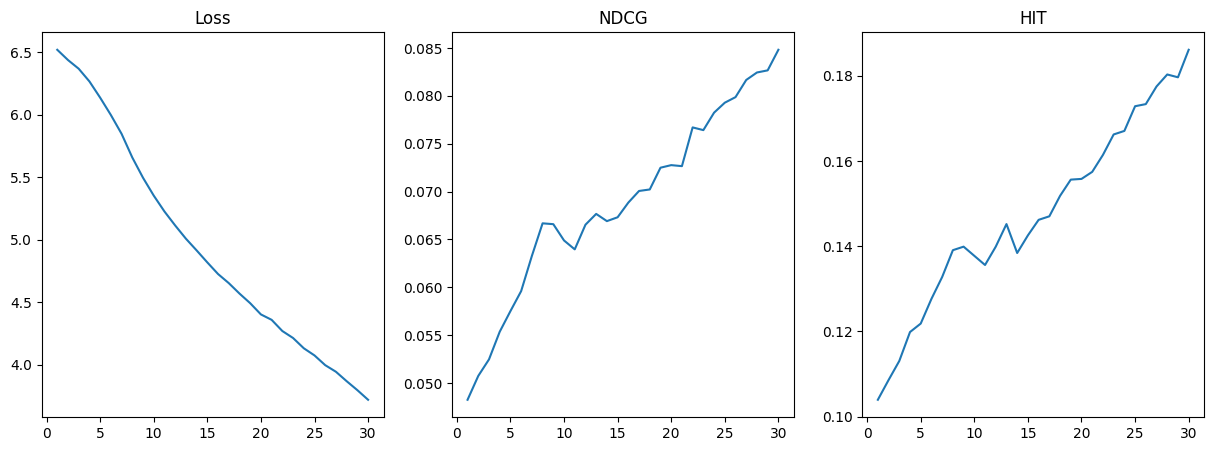

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()


In [33]:
# Use the modified test function after training

# 테스트 실행
ndcg, hit = test(
    model=model,
    user_test=user_test,
    max_len=config.max_len,
    sasrec_dataset=sasrec_dataset
)

print(f'NDCG@10: {ndcg}, HIT@10: {hit}')

NDCG@10: 0.08615022044196342, HIT@10: 0.1849337748344371
